In [16]:
%matplotlib inline
from pylab import *
import dataset
import fullyconn
from IPython import display

# Loading data

In [17]:
data = dataset.load_dataset()
train_data = data[:-len(data)/2]
test_data = data[:len(data)/2]

Loading dataset.bin


 # Model plan (fcc autoencoder 1600-30-1600 with MSE loss)

In [18]:
def build_nn():
    print("Building NN")
    nn = fullyconn.MLP(1600)
    nn.add_layer("bottleneck", 30)
    nn.add_layer("reconstruction", 1600)
    return nn

# Evaluation function (test set)

In [19]:
def test_precision(encode_decode):
    # L1 distance between original example and encoded-decoded example
    precision = np.absolute(test_data - encode_decode(test_data)).sum()
    # Normalization
    precision = precision / 1600 / len(test_data)
    return precision

# Reconstruction visualisation

In [20]:
import Image
def show_reconstruction(example, encode_decode):
    reconstructed = encode_decode(np.array([example]))
    
    example = np.array(example.reshape(40, 40) * 255, dtype="uint8")
    reconstructed = np.array(reconstructed.reshape(40, 40), dtype="float32")
    
    figure()
    subplot(121)
    imshow(example, cmap=cm.binary, interpolation="nearest")
    subplot(122)
    imshow(reconstructed, cmap=cm.binary, interpolation="nearest")

# Model training

In [23]:
def train_network(nn, learning_rate, batch_size, steps):
    epoch = []
    train = nn.build_train(learning_rate)
    eval  = nn.build_eval()
    for step_id in range(steps):
        for batch_id in range(0, len(train_data) / batch_size):
            ts = train_data[batch_id * batch_size: (batch_id + 1) * batch_size]

            train(ts, ts)
            
            if batch_id % 100 == 0:
                precision = test_precision(eval)
                epoch.append(precision * 100)
                for i in range(5):
                    show_reconstruction(test_data[i], eval)
                display.clear_output(wait=True)
                figure()
                x = linspace(0, len(epoch) * 100, len(epoch))
                plot(x, epoch, 'r')
                show()

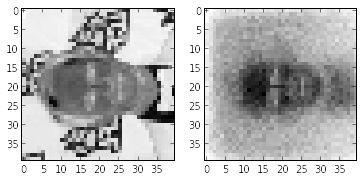

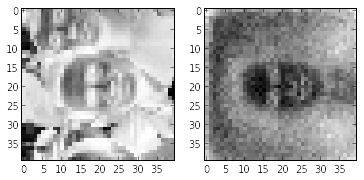

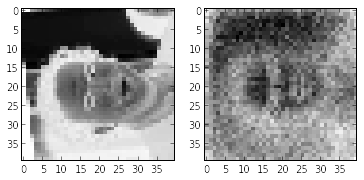

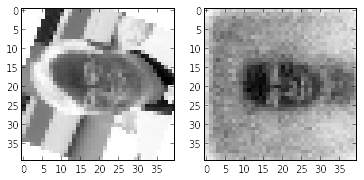

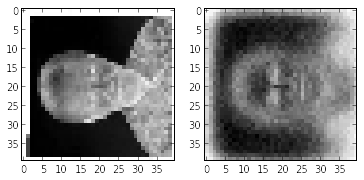

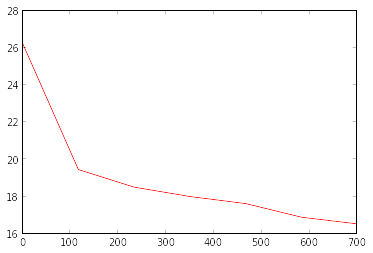

In [ ]:
train_network(build_nn(), 0.005, 10, 100)